# Unit 8 Lecture 2 - Statistical Inference

ESI4628: Decision Support Systems for Industrial Engineers<br>
University of Central Florida
Dr. Ivan Garibay, Ramya Akula, Mostafa Saeidi, Madeline Schiappa, and Brett Belcher. 
https://github.com/igaribay/DSSwithPython/blob/master/DSS-Week08/Notebook/DSS-Unit08-Lecture02.2018.ipynb

## Notebook Learning Objectives
After studying this notebook students should be able to:
- Understand basic concepts of statistical inference
- Calculate the empirical distribution of the sample mean
- Calculate the empirical and theoretical standar error of the mean distribution
- Calculate the mean sampling distribution using the bootstrapping method
- Calculate confidence intervals for a given variable
- Undestand the basic concepts of hypothesis testing
- Test hypothesis using confidence intervals and p-values

# Overview

## Statistical inference.

In this notebook we will see how to infer predictions about a population. To
this end we will explore the relationship between **sample parameters** and **population parameters** and we will propose some methods to assess the quality
of parameter estimates of a sample.

## Accidents in Barcelona data set

Let's consider a dataset of accidents in Barcelona in 2013. This dataset can
be downloaded from OpenDataBCN website (http://opendata.bcn.cat/),
Barcelona's City Hall open data service. Each register in the dataset represents an accident by a series of features: weekday, hour, address, number
of dead and injured people, etc. This dataset will represent our population:
the set of all reported traffic accidents in Barcelona during 2013.

In https://dieguico.cartodb.com/viz/50b06d8c-13ab-11e5-8619-0e4fddd5de28/public_map you can visualize a map of accidents in the city of Barcelona by hour of day, and by day of week.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import pandas as pd
import numpy as np
import random

%matplotlib inline

In [2]:
data = pd.read_csv('../Data/ACCIDENTS_GU_BCN_2013.csv',encoding='latin-1')
print data.columns

Index([u'Número d'expedient', u'Codi districte', u'Nom districte', u'NK barri',
       u'Nom barri', u'Codi carrer', u'Nom carrer', u'Num postal caption',
       u'Descripció dia setmana', u'Dia de setmana', u'Descripció tipus dia',
       u'NK Any', u'Mes de any', u'Nom mes', u'Dia de mes', u'Hora de dia',
       u'Descripció torn', u'Descripció causa vianant', u'Número de morts',
       u'Número de lesionats lleus', u'Número de lesionats greus',
       u'Número de víctimes', u'Número de vehicles implicats',
       u'Coordenada UTM (Y)', u'Coordenada UTM (X)'],
      dtype='object')


We will create a new data column which is the date and a list with the number of accidents for every day of the year:

In [3]:
#Create a new column which is the date
data['Date'] = '2013-'+data['Mes de any'].apply(lambda x : str(x)) + '-' +  data['Dia de mes'].apply(lambda x : str(x))
data['Date'] = pd.to_datetime(data['Date'])
accidents = data.groupby(['Date']).size()
Population_Mean = accidents.mean()
print " Population Mean:", Population_Mean

 Population Mean: 25.9095890411


Let's suppose that we are interested in describing the number of daily traffic
accidents (**accident rate**) in the streets of Barcelona during 2013.  In order to get a first idea of the data, we can plot the number of accidents for each day of 2013:

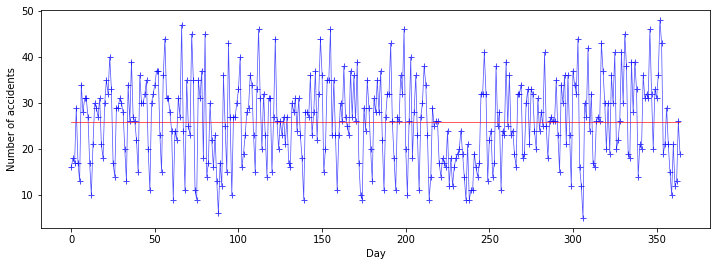

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.ylabel('Number of accidents')
plt.xlabel('Day')
plt.plot(range(0, 365), np.array(accidents), 'b-+', lw=0.7, alpha=0.7)
plt.plot(range(0, 365), [accidents.mean()]*365, 'r-', lw=0.7, alpha=0.9)
plt.show()

Alternatively, we can plot the distribution of our variable of interest: the daily number of accidents.

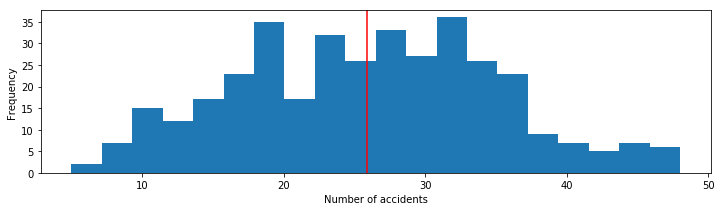

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.ylabel('Frequency')
plt.xlabel('Number of accidents')
plt.hist(np.array(accidents), bins=20)
ax.axvline(x=accidents.mean(), ymin=0, ymax=40, color=[1, 0, 0])
plt.savefig("bootmean.png",dpi=300, bbox_inches='tight')
plt.show()

If we have access to the whole *population*, the computation of the **accident rate** in 2013 is a simple operation: the total number of accidents divided by 365. As a measure of quality of this parameter we can also compute the standard deviation.

In [6]:
print "Mean:", accidents.mean(), "; STD:", accidents.std()

Mean: 25.9095890411 ; STD: 9.10832496246


But now, let's suppose that we have only access to a limited part of the data
(the *sample*): the number of accidents during *some days* of 2013. Can we still
give an approximation (an *estimate*) to this population mean?

# Meassuring variability of estimates

Estimates generally vary from one sample to another, and this sampling variation suggests our estimate may be close, but it will not be exactly equal to the parameter.

This can be easily checked by generating 10 different samples (composed of 25% of the population) from our population and compute their accident rate estimates:

In [7]:
df = accidents.to_frame()
m = []

for i in range(10):
    df['for_testing'] = False
    # get a 25% sample 
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.25)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    accidents_sample = df[df['for_testing'] == True]
    m.append(accidents_sample[0].mean())
    print  'Sample '+str(i)+': Mean', '%.2f' % accidents_sample[0].mean()


Sample 0: Mean 27.21
Sample 1: Mean 25.59
Sample 2: Mean 25.78
Sample 3: Mean 25.27
Sample 4: Mean 25.01
Sample 5: Mean 25.65
Sample 6: Mean 25.86
Sample 7: Mean 26.38
Sample 8: Mean 25.38
Sample 9: Mean 26.80


In [8]:
print df.shape

(365, 2)


Text(0.5,0,u'Sample')

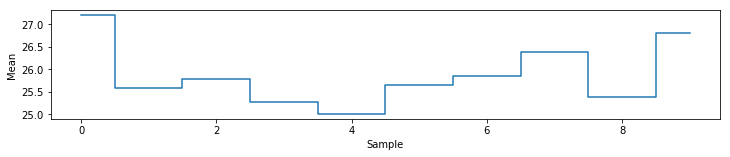

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
x = range(10)
ax.step(x,m, where='mid')
ax.set_ylabel('Mean')
ax.set_xlabel('Sample')

Accident rate estimates can range from 24 accident per day to 27 accidents per day, depending on the sample. How can we give a unique value for the estimate?

# Point estimates

The most intuitive way to go about giving a value for the estimate is to simply take the **sample
mean**. The sample mean is a **point estimate** of the population mean. If we
can only choose one value to estimate the population mean, this is our best
guess.

## Sample distribution of point estimates

Let's computer the sample means for a set of 10000 samples, each one composed of 200 days: 


Population: df.shape= (365, 1)
Mean of sample mean: 25.924423500000003
True Mean : 25.9095890411
Difference(%): -0.05725470550915448 %


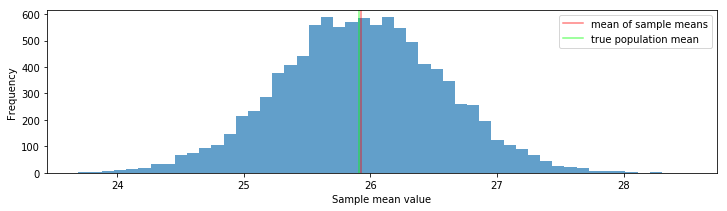

In [10]:
plt.autumn()

# population
df = accidents.to_frame()    # to a data frame
print "Population: df.shape=", df.shape
N_test = 10000                 # how many samples 
elements = 200              # how many elements each sample would have, sample size

# mean array of samples
means = [0] * N_test      # array to store the means for each sample

# sample generation
for i in range(N_test):          
    rows = np.random.choice(df.index.values, elements) # random sampling 200 elements form df.index.values
    sampled_df = df.loc[rows]
    means[i] = sampled_df.mean()
    
fig, ax = plt.subplots(1, 1, figsize=(12,3))

plt.hist(np.array(means),bins=50, alpha=0.7)
plt.ylabel('Frequency')
plt.xlabel('Sample mean value')
ax.axvline(x = np.array(means).mean(), 
           ymin = 0, 
           ymax = 700, 
           color = [1, 0, 0], label="mean of sample means", alpha=0.5)
ax.axvline(x = Population_Mean, 
           ymin = 0, 
           ymax = 700, 
           color = [0, 1, 0], label="true population mean", alpha=0.5)
plt.savefig("empiricalmean.png",dpi=300, bbox_inches='tight')
plt.set_cmap(cmap=cm.Pastel2)
plt.legend()

print "Mean of sample mean:", np.array(means).mean()
print "True Mean :", Population_Mean
print "Difference(%):", ((Population_Mean-np.array(means).mean())/Population_Mean)*100,"%"

This is the **sampling distribution of the mean**. From it we could estimate the most probable value of the mean and also its standard deviation, but in the real world we will not have access to this function!
- **Note:** Here experiment with changing the value for <code>N_test</code>. Some values to try <code>N_test=2</code>, <code>N_test=10</code>,<code>N_test=100</code>,<code>N_test=1000</code>,<code>N_test=10000</code>. What happends with the histogram? why?
- **Note:** Execute the cell below several time for <code>N_test=10</code>. What happen with the "mean of sameple means" red line? How is compare after each execution with the _true_ population mean represented by the green line?

## Standar error of point estimates

The standard error of an estimated parameter is the standard deviation of its sample distribution. For our case, the **standard error** of the mean is the **standard deviation of the sample distribution** of the mean. This standar error is an important value since quantifies the error associated with our point estimates.

### (1) Estimating standar error using multiple samples: direct approach

Since in the above example we have access to the entire population, we can calculate the **standard error** of the mean by simply calculating standard deviation of the sampling distribution of the mean calculated above. 

In [27]:
 np.array(means).std()

0.6451918359276951

### (2) Estimating standar error using a single sample: traditional approach

In real world problems, we do not have acccess to the entire population to sample at will. In fact, in many cases we only have one sample of the propulation. In these cases we can still calcualte an estimate of the standar error if we rely on a theoretical result derived from the _Central Limit Theorem_.

It can be mathematically shown that given $n$ independent observations (samples) $\{ x_i \}_{i=1,..,n}$ from a population with a standard deviation $\sigma_x$, the standard deviation of the sample mean $\sigma_{\bar{x}}$, or **standard error** is:

$$ SE = \sigma_{\bar{x}} = \frac{\sigma_{x}}{\sqrt{n}} \approx \frac{Estimated(\sigma_{x})}{\sqrt{n}} $$

Where $Estimated(\sigma_{x})$ is the standard deviation calculated from the single available sample of the population.

**Note:** Usually, $\sigma_x$ is not known and it is substituted by its empirical estimate $Estimated(\sigma_{x})$ calculated using a single sample. This estimate is sufficiently good of $n>30$ and the population distribution is not skewed)



In [28]:
rows = np.random.choice(df.index.values, 200)
sampled_df = df.loc[rows]
est_sigma_mean = sampled_df.std()/math.sqrt(200)
est_sigma_mean

0    0.644688
dtype: float64

### (3) Estimating standar error: bootstrapping approach

For this example, let's consider that the entire accidents dataset as a sample from an hypothetical population (this is the most common situation when analyzing real world data: single sample).

A modern alternative to the traditional approach to statistical inference is
the *bootstrapping method*. In the bootstrap, we draw $N$ observations with
replacement from the original data to create a bootstrap sample or **resample**.
Then, we can calculate the mean for this resample. By repeating this process
a large number of times we can built a good approximation of the mean
sampling distribution.

Below, we resample the "accidents" series created above. This series contains the 365 days of 2013 and the accident frequency for each date. We resample the original sample 10,000 times. Each resample draws also 365 elements from the orignal sample:

In [29]:
accidents.size

365

In [30]:
accidents.head()

Date
2013-01-01    16
2013-01-02    18
2013-01-03    17
2013-01-04    29
2013-01-05    17
dtype: int64

In [31]:
def meanBootstrap(X,N_resamples): #X, Series input to be resampled (accidents)
                                 # N_resamples: N, number of resamples
    x = [0]*N_resamples         # x, array to store means for each resample
    for i in range(N_resamples): # i from 0 to (N_resamples - 1)
        #calculate re-sample indexes, re-sample size = original sample size
        #return len(X) random numbers between 0 and len(X)
        resample_index = np.random.randint(len(X), size=len(X)) 
        #calculating the resample from X
        subsample = X[resample_index]  
        #calculating the mean of each resample, store in x[i] 
        x[i] = np.mean(subsample)            
    return x
m = meanBootstrap(accidents, 10000) # m=(meanBootstrap returns x)
print "Mean estimate:", np.mean(m)  # accidents= Series containing date and frequency of accidents for that date

Mean estimate: 25.90512684931507


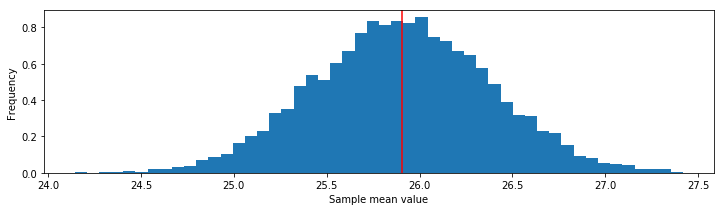

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.ylabel('Frequency')
plt.xlabel('Sample mean value')
plt.hist(m, 
         bins = 50, 
         density = True)
ax.axvline(x = np.mean(m), 
           ymin = 0.0, 
           ymax = 1.0, 
           color = [1, 0, 0])

The boostrapping method can be applied to other simple estimates such as
the median or the variance:

In [33]:
def medBootstrap(X,N_resamples):                             
    x = [0]*N_resamples         
    for i in range(N_resamples): 
        resample_index = np.random.randint(len(X), size=len(X)) 
        subsample = X[resample_index]  
        x[i] = np.median(subsample)            
    return x
m = medBootstrap(accidents, 10000) 
print "Median estimate:", np.mean(m)  

Median estimate: 26.2959


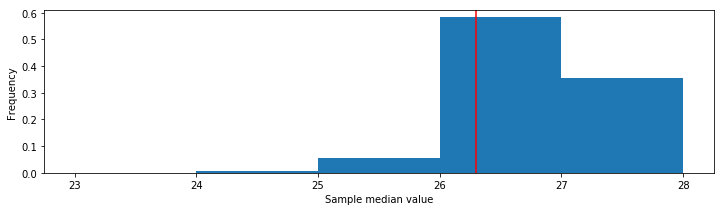

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.hist(m, bins=5, density=True)
plt.ylabel('Frequency')
plt.xlabel('Sample median value')
ax.axvline(x = np.array(m).mean(), 
           ymin = 0, 
           ymax = 1.0, 
           color = [1, 0, 0])

# Confidence Intervals

A point estimate provides a single plausible value for a parameter. However,
as we have seen a point estimate is rarely perfect; usually there is some error
in the estimate. As seen above, we meassure its variability using the standard error.

As an alternative, we can provide a **plausible range of
values** for the parameter. A plausible range of values for the sample parameter
is called a **confidence interval**.

We will base the definition of confidence interval on two ideas:

+ Our point estimate is the most plausible value of the parameter, so it makes sense to build the confidence interval around the point estimate.

+ The plausability of a range of values can be defined from the sampling distribution of the estimate.

For the case of the mean, the _Central Limit Theorem_ asserts that it is **normal**.

### Central Limit Theorem (Laplace, 1810)

> Take the mean of $n$ random samples from ANY arbitrary distribution with a $well$ $defined$ standard deviation $\sigma$ and mean $\mu$. As $n$ gets bigger the **distribution of the sample mean** will always converge to a Gaussian (normal) distribution with mean $\mu$ and standard deviation $\frac{\sigma}{\sqrt{n}}$.

Colloquially speaking, the theorem states the distribution of an average tends to be normal, even when the distribution from which the average is computed is decidedly non-normal. This explains the ubiquity of the Gaussian distribution in science and statistics. 

In order to define an interval, we can make use of a well
known result from probability that applies to normal distributions: roughly
95% of the time our estimate will be within 1.96 standard errors of the true
mean of the distribution.

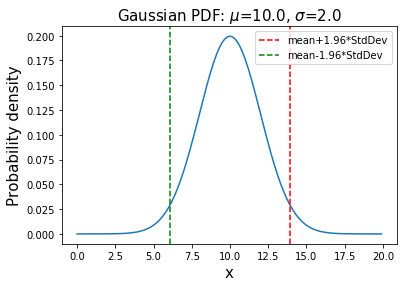

In [35]:
u=10 # mean
s=2 # standard deviation
x=np.arange(0,20,0.1)
y=(1/(np.sqrt(2*np.pi*s*s)))*np.exp(-(((x-u)**2)/(2*s*s)))
plt.plot(x,y,'-')
plt.title('Gaussian PDF: $\mu$=%.1f, $\sigma$=%.1f' % (u,s),fontsize=15)
plt.xlabel('x',fontsize=15)
plt.ylabel('Probability density',fontsize=15)
plt.axvline(x=u+1.96*s, color = 'r', linestyle='--', label='mean+1.96*StdDev')
plt.axvline(x=u-1.96*s, color = 'g', linestyle='--', label='mean-1.96*StdDev')
plt.legend()
plt.show()

Since the interval spreads 1.96 standar errors from a normaly distributed point estimate, we can say that 

> **we are 95% confident that we have achieved the true parameter**

$$CI = [ \theta - 1.96 \times SE , \theta + 1.96 \times SE] $$

$$CI = [ \theta - 1.96 \times \frac{Estimated(\sigma_{x})}{\sqrt{n}} , \theta + 1.96 \times \frac{Estimated(\sigma_{x})}{\sqrt{n}}] $$

In [36]:
mean = accidents.mean()
se = accidents.std()/math.sqrt(len(accidents))
ci = [mean - se*1.96, mean + se*1.96]
print "mean:", mean
print "standar deviation", se
print "Confidence interval:", ci


mean: 25.9095890411
standar deviation 0.476751518008
Confidence interval: [24.975156065800284, 26.8440220163915]


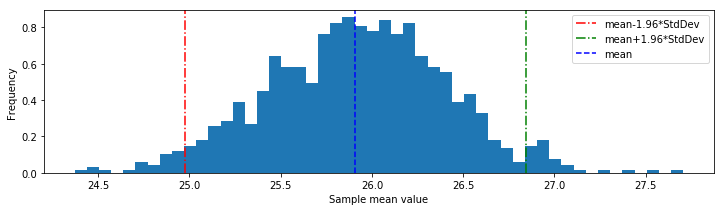

In [37]:
m = meanBootstrap(accidents, 1000) 
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.ylabel('Frequency')
plt.xlabel('Sample mean value')
plt.hist(m, 
         bins = 50, 
         density = True)
plt.axvline(x=ci[0], color = 'r', linestyle='-.', label='mean-1.96*StdDev')
plt.axvline(x=ci[1], color = 'g', linestyle='-.', label='mean+1.96*StdDev')
plt.axvline(x=mean, color = 'b', linestyle='--', label='mean')
plt.legend()

This is how we would compute a 95% confidence interval of the sample mean by using bootstrapping:

1. Repeat the following steps a large number $M$ of times: 
    + Draw $N$ observations with replacement from the original data to create a bootstrap sample or resample; 
    + Calculate the mean for the resample.
2. Calculate the **mean** of your $M$ values of the sample statistic. This process gives you a “bootstrapped” estimate of the sample statistic.
3. Calculate the **standard deviation** of your $M$ values of the sample statistic. This process gives you a “bootstrapped” estimate of the **SE** of the sample statistic.
4. Obtain the 2.5th and 97.5th centiles of your $M$ values values of the sample statistic.

In [38]:
m = meanBootstrap(accidents, 1000)
sample_mean = np.mean(m)
sample_se =  np.std(m)

print "Mean estimate:", sample_mean
print "SE of the estimate:", sample_se

ci2 = [np.percentile(m,2.5), np.percentile(m,97.5)]
print "Confidence interval (bootstrap):", ci2

Mean estimate: 25.889975342465753
SE of the estimate: 0.48831295102858024
Confidence interval (bootstrap): [25.002465753424655, 26.87958904109589]


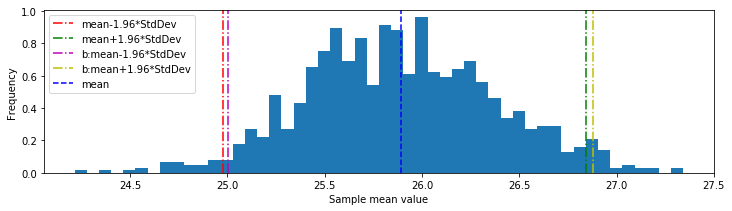

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.ylabel('Frequency')
plt.xlabel('Sample mean value')
plt.hist(m, 
         bins = 50, 
         density = True)
plt.axvline(x=ci[0], color = 'r', linestyle='-.', label='mean-1.96*StdDev')
plt.axvline(x=ci[1], color = 'g', linestyle='-.', label='mean+1.96*StdDev')
plt.axvline(x=ci2[0], color = 'm', linestyle='-.', label='b:mean-1.96*StdDev')
plt.axvline(x=ci2[1], color = 'y', linestyle='-.', label='b:mean+1.96*StdDev')
plt.axvline(x=sample_mean, color = 'b', linestyle='--', label='mean')
plt.legend()

### What is the real meaning of CI?

The real meaning of "confidence" is not evident and it must be understood
from the point of view of the generating process.

Suppose we take many (infinite) samples from a population and built a
95% confidence interval from each sample. Then about 95% of those intervals
would contain the actual true parameter.

This can be easily showed by simulating a large number of samples and checking how many intervals contain the true parameter:

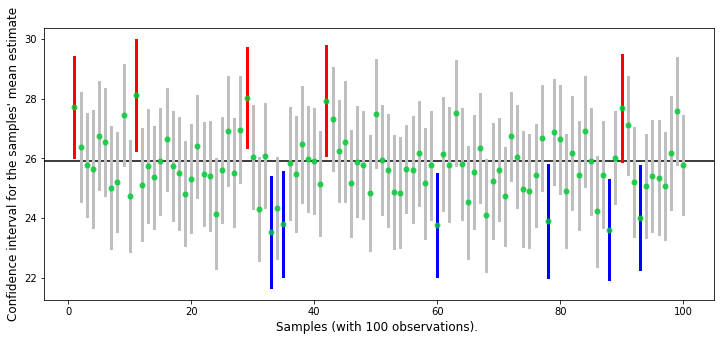

In [44]:
df = accidents   

n = 100                                               # number of observations
N_test = 100                                          # number of samples with n observations
means = np.array([0.0] * N_test)                      # samples' mean
s = np.array([0.0] * N_test)                          # samples' std
ci = np.array([[0.0,0.0]] * N_test)
tm = df.mean()                                        # "true" mean

for i in range(N_test):                               # sample generation and CI computation
    rows = np.random.choice(df.index.values, n)
    sampled_df = df.loc[rows]
    means[i] = sampled_df.mean()
    s[i] = sampled_df.std()
    ci[i] = means[i] + np.array([-s[i] *1.96/np.sqrt(n), s[i]*1.96/np.sqrt(n)])    

out1 = ci[:,0] > tm                                   # CI that do not contain the "true" mean
out2 = ci[:,1] < tm

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ind = np.arange(1, N_test+1)
ax.axhline(y = tm, 
           xmin = 0, 
           xmax = N_test+1, 
           color = [0, 0, 0])
ci = np.transpose(ci)
ax.plot([ind,ind], 
        ci, 
        color = '0.75', #grey
        marker = '_', 
        ms = 0, 
        linewidth = 3)
ax.plot([ind[out1],ind[out1]], 
        ci[:, out1], 
        color = 'r', #color = [1, 0, 0, 0.8], 
        marker = '_', 
        ms = 0, 
        linewidth = 3)
ax.plot([ind[out2],ind[out2]], 
        ci[:, out2], 
        color = 'b', #color = [1, 0, 0, 0.8], 
        marker = '_',
        ms = 0, 
        linewidth = 3)
ax.plot(ind, 
        means, 
        color = [0, .8, .2, .8], #green
        marker = '.',
        ms = 10, 
        linestyle = '')
ax.set_ylabel("Confidence interval for the samples' mean estimate",
              fontsize = 12)
ax.set_xlabel('Samples (with %d observations). '  %n, 
              fontsize = 12)
plt.savefig("confidence.png",
            dpi = 300, 
            bbox_inches = 'tight')
plt.show()

The correct interpretation of the confidence interval is:
> In 95% of the cases, when we compute the 95% confidence interval from this sample, the true mean of the population will fall between the interval defined by $\pm 1.96 \times SE$.

# Hypothesis testing

To give a measure of variability of our estimates is a way of producing a
statistical proposition about the population, but not the only one. R.A.Fisher
(1890-1962) proposed an alternative, known as *hypothesis testing*, that is
based on the concept of *statistical significance*.

Let's suppose that a deeper analysis of traffic accidents in Barcelona results
in a difference between 2010 and 2013. Of course, the diference could be caused only by chance, because of the variability of both estimates. But it
could also be the case that traffic conditions are very diferent in Barcelona
during these two periods and, because of this, data from these two periods can
be considered as belonging to two diferent populations. Then, the relevant
question is: Are the observed effects real or not?

The process of determining the statistical significance of an effect is called
**hypothesis testing**. This process starts by simplifying the options into two
competing hypotheses:

+ $H_0$: The mean number of daily traffic accidents is the same in 2013 and 2010 (there is only one population, one true mean, and 2010 and 2013 are just different samples from the same population).

+ $H_A$: The mean number of daily traffic accidents for 2010 and for 2013 is different (2010 and 2013 are two samples from two different populations).

We call $H_0$ the *null hypothesis* and it represents a skeptical point of view:
the effect we have observed is due to chance (due to the specific sample bias).

$H_A$ is the *alternative hypothesis* and it represents the other point of view:
the effect is real.

The general rule of frequentist hypothesis testing is: We will not discard $H_0$
(and hence we will not consider $H_A$) unless the observed effect is implausible
under $H_0$.

## Testing hypotheses using confidence intervals

We can use the concept represented by confidence intervals to measure the
plausibility of an hypothesis.

We can illustrate the evaluation of the hypotheses setup by comparing the
mean rate of traffic accidents in Barcelona during 2010 and 2013 using a point estimate from the 2013 sample:

In [45]:
data = pd.read_csv("../Data/ACCIDENTS_GU_BCN_2010.csv", encoding='latin-1')
#Create a new column which is the date
data['Date'] = data['Dia de mes'].apply(lambda x : str(x)) + '-' +  \
               data['Mes de any'].apply(lambda x : str(x))
data2 = data['Date']
counts2010 =data['Date'].value_counts()
print '2010: Mean', counts2010.mean()

data = pd.read_csv("../Data/ACCIDENTS_GU_BCN_2013.csv", encoding='latin-1')
#Create a new column which is the date
data['Date'] = data['Dia de mes'].apply(lambda x : str(x)) + '-' +  \
               data['Mes de any'].apply(lambda x : str(x))
data2 = data['Date']
counts2013 = data['Date'].value_counts()
print '2013: Mean', counts2013.mean()

2010: Mean 24.8109589041
2013: Mean 25.9095890411


This estimate suggests that during 2013 the mean rate of
traffic accidents in Barcelona **was higher** than 2010. But is this effect statistically significant?

Based on our sample, the 95% confidence interval for the mean rate of
traffic accidents in Barcelona during 2013 can be calculated as:

In [46]:
n = len(counts2013)
mean = counts2013.mean()
s = counts2013.std()
ci = [mean - s*1.96/np.sqrt(n),  mean + s*1.96/np.sqrt(n)] 
print '2010 accident rate estimate:', counts2010.mean()
print '2013 accident rate estimate:', counts2013.mean()
print 'CI for 2013:',ci

2010 accident rate estimate: 24.8109589041
2013 accident rate estimate: 25.9095890411
CI for 2013: [24.975156065800284, 26.8440220163915]


Because 2010 accident rate estimate does not fall in the range of plausible values of 2013, we say the
alternative hypothesis cannot be discarted. That is, it can not be discarted that during 2013 the mean rate of traffic accidents in Barcelona was higher than during 2010.

## Testing hypotheses using P-values.

A more advanced notion of statistical significance was developed by R.A.Fisher
in the 1920's when looking for a test to decide whether variation in crop yields
were due to some specific intervention or merely randon factors beyond experimental control.
Fisher first assumed that fertilizer caused no difference (null hypothesis)
and then calculated $P$, the probability that an observed yield in a fertilized
field would occur if fertilizer had no real effect. This probability is called
p-value.

The p-value is the probability of observing data at least as favorable to
the alternative hypothesis as our current data set, if the null hypothesis is
true.

The goal of hypothesis testing is to answer the question: **Given a sample and an apparent effect, what is the probability of seen the effect by chance?**

To apply a test of hypotheses to our problem, we proceed as follows:

- The **first step** is to quantify the size of the apparent effect by choosing a test statistic. In our case, the apparent effect is a difference in accident
rates, so a natural choice for the test statistic is the difference in means
between the two periods:

In [47]:
m = len(counts2010)
n = len(counts2013)
p = (counts2013.mean() - counts2010.mean())
print 'm:',m, 'n:', n
print 'mean difference: ', p

m: 365 n: 365
mean difference:  1.09863013699


- The **second step** is to define a null hypothesis, which is a model of the
system based on the assumption that the apparent effect is not real. In
our case the null hypothesis is that there is no diference between the two
periods. The alternative hypothesis is that during 2013 the mean rate of traffic accidents in Barcelona was higher than 2010.

- The **third step** is to compute a p-value, which is the probability of seeing
the apparent effect if the null hypothesis is true. In our case, we would
compute the absolute difference in means, then compute the probability
of seeing a difference as big, or bigger, under the null hypothesis.

Usually, if p is less than 0.05 (the chance of a 
fluke is less than 5%) the
result is declared statistically significant.

To approximate the p-value, we can follow the following procedure:
1. Pool the distributions
2. Generate samples with size $n$ and compute the difference in the mean
3. Count how many differences are larger than the observed one

Text(0.5,1,u'Pooled distribution')

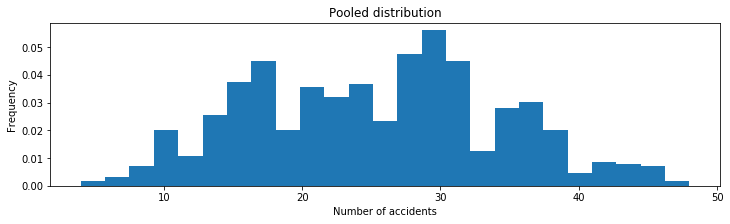

In [48]:
x = counts2010
y = counts2013
pool = np.concatenate([x,y])
np.random.shuffle(pool) #randomize order

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.hist(pool, 
         bins = 25, 
         density = True)
plt.ylabel('Frequency')
plt.xlabel('Number of accidents')
plt.title("Pooled distribution")

Text(0.5,0,u'Difference in the mean')

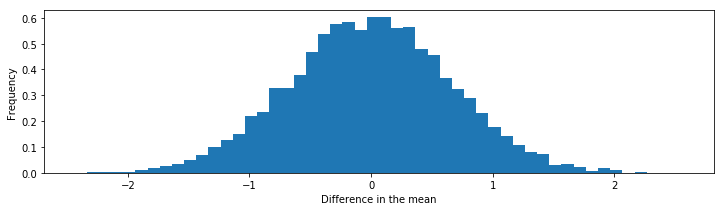

In [49]:
N = 10000 # number of samples
diff = range(N)
for i in range(N):
    p1 = [random.choice(pool) for _ in xrange(n)]
    p2 = [random.choice(pool) for _ in xrange(n)]
    diff[i] = (np.mean(p1)-np.mean(p2))

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.hist(diff, 
         bins = 50, 
         density = True)
plt.ylabel('Frequency')
plt.xlabel('Difference in the mean')

In [50]:
# counting how many differences are larger than the observed one
diff2 = np.array(diff)
w1 = np.where(diff2 > p)[0]      #p = (counts2013.mean() - counts2010.mean())
len(w1)

468

If there are $k$ sample pairs where the difference in mean is as big as or bigger than 0.05, the p-value is approximately $k/N$, where $N$ is the number of samples. In our case:

In [51]:
print 'p-value (Simulation)=', len(w1)/float(N), '(', len(w1)/float(N)*100 ,'%)', 'Difference =', p
if len(w1)/float(N)<0.05:
    print 'The effect is likely'
else:
    print 'The effect is not likely'

p-value (Simulation)= 0.0468 ( 4.68 %) Difference = 1.09863013699
The effect is likely


We have defined the effect as a difference in mean as
big or bigger than the observed difference, taking into account the sign. A test like this is called *one-sided*.

If the relevant question is whether accident rates are different, then it
makes sense to test the absolute difference in means. This kind of test is called *two-sided*
because it  counts both sides of the distribution of differences.

## Interpreting P-Values

- p-value is the probability that a given observed phenomena arising only by chance
- p-value $\leq 0.05$  implies
    - the phenomena is real OR
    - there is an improbable fluke
  

# References
1. Traffic accidents data, http://opendata.bcn.cat/
2. Plot on map of the accidents in Barcelona, https://dieguico.cartodb.com/viz/50b06d8c-13ab-11e5-8619-0e4fddd5de28/public_map 

_Last updated on 10.16.18 1:28am<br>
(C) 2018 Complex Adaptive Systems Laboratory all rights reserved._